# QAOA Test

As the las notebook was getting a little bigger than I would have wanted, I created a new notebook. I will transfer all the qaoa functions and the ones back in `test.ipynb` will probably become outdated

In [29]:
from qiskit.quantum_info import Pauli,SparsePauliOp,Statevector
from typing import Union
from colorama import Fore
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2
from qiskit.visualization import plot_histogram

In [35]:
def interaction_term(qc: QuantumCircuit, phi, control, target)->QuantumCircuit:
    r"""
    Builds the gate from the interaction term in the Ising Hamiltonian
    
    Args:
        `qc`: The quantum circuit to be added
        `phi`: The parameter $\phi$ from the optimization
        `control`: The position of the control qubit
        `target`: The position of the target qubit
    
    Returns:
        The modified QuantumCircuit    
    """
    
    qc.cx(control,target)
    qc.rz(phi*2,target)
    qc.cx(control,target)
    qc.barrier()
    
    return qc

def circuit_size(qc:QuantumCircuit)->int:
    r"""Utility function to get the number of registers of a QuantumCircuit"""
    size = 0
    for reg in qc.qregs:
        size+=reg.size
    return size
    

In [78]:
# Transforms a Pauli expression to a supported quadratic expression
def pauliop_to_exp(op:SparsePauliOp)->str:
    exp = ''
    for i,pauli in enumerate(op.paulis):
        exp+=str(int(op.coeffs[i].real))
        for i,char in enumerate(pauli.to_label()):
            if char == 'Z':
                exp+='Z'+str(i)
        exp+='+'
    exp = exp[:-1]
    return exp

In [79]:
# Function to automatize layers of an ansatz
def create_ansatz_layer(qc:QuantumCircuit,expression:Union[str,SparsePauliOp],phi=1,beta=1)->QuantumCircuit:
    r"""
    Creates an ansatz layer. However you need to start your circuit with h gates to enter superposition.
    
    Args:
        `qc`: QuantumCircuit to be modified.
        `expression`: Hamiltonian to optimize. Either in str or pauli expression.
        `phi`: Parameter for the Z rotations.
        `beta`: Parameter for the X rotations.
    
    Returns:
    The QuantumCircuit with the added ansatz.
    
    """
    if type(expression) == SparsePauliOp:
        expression = pauliop_to_exp(expression)
    #Read expression
    expression = expression.replace(' ', '')
    
    # Standardize the polynomial string to handle positive terms properly
    expression = expression.replace('-', '+-')
    if expression[0] == '+':
        expression = expression[1:]
    
    # Split the string into terms
    terms = expression.split('+')
    
    for term in terms:
        gate = term.count('Z')
        coefs = term.split('Z')
        if coefs[0] == '':
            coefs[0]=1
        if coefs[0] == '-':
            coefs[0]=-1
        coefs = [int(t) for t in coefs]
        if gate == 1:
            qc.rz(2*coefs[0]*phi,coefs[1])
            qc.barrier()
        else:
            qc = interaction_term(qc,coefs[0]*phi,coefs[1],coefs[2])
            
    size = circuit_size(qc)
    for i in range(size):
        qc.rx(2*beta,i)
    qc.barrier()
    return qc

# Create full ansatz (kind of stupid)
def create_ansatz(qc:QuantumCircuit,expression:str,layers=1,phi=1,beta=1):
    r"""
    Creates an ansatz. However you need to start your circuit with h gates to enter superposition.
    
    Args:
        `qc`: QuantumCircuit to be modified.
        `expression`: Hamiltonian to optimize. Either in str or pauli expression.
        `layers`:Number of layers to be added
        `phi`: Parameter for the Z rotations.
        `beta`: Parameter for the X rotations.
    
    Returns:
    The QuantumCircuit with the added ansatz.
    
    """
    for _ in range(layers):
        qc = create_ansatz_layer(qc,expression,phi,beta)
    return qc

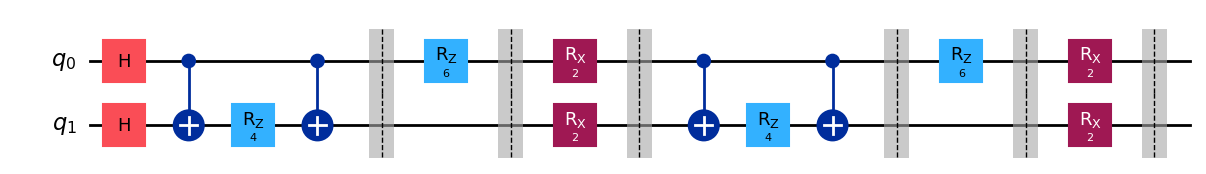

In [80]:
expression = "2Z0Z1+3Z0"
size = 2

qc = QuantumCircuit(size)

for i in range(size):
    qc.h(i)
    
qc=create_ansatz(qc,expression,2)

qc.draw('mpl')

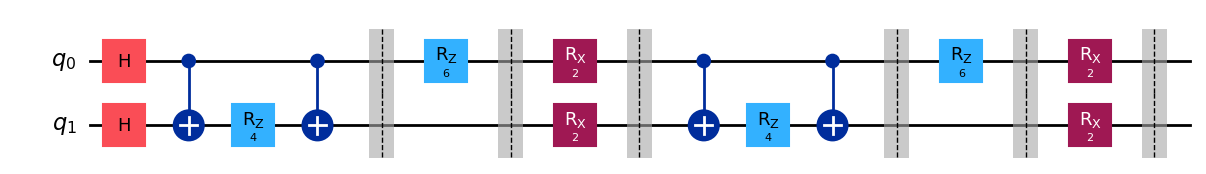

In [81]:
op = 2* SparsePauliOp(Pauli('ZZ'))+3*SparsePauliOp(Pauli('ZI'))

size = 2

qc = QuantumCircuit(size)

for i in range(size):
    qc.h(i)
    
qc=create_ansatz(qc,op,2)

qc.draw('mpl')